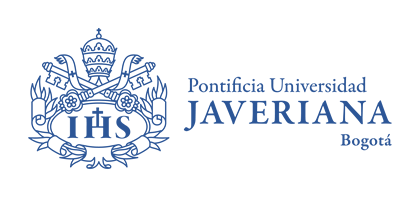

# Taller Uber - Ejemplo redes Neuronales
- Juan Sebastián Vargas Torres

## Imports

In [ ]:
pip install h3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import h3
import numpy as np
from numpy import pi
import tensorflow.compat.v2 as tf
import seaborn as sns
from sklearn.model_selection import train_test_split 
import sklearn.datasets
from sklearn.datasets import make_blobs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from geopy.geocoders import Nominatim
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Uber


Cree un modelo feed forward con keras para resolver el siguiente problema


##  Uber Fares regression problem
Uber ha publicado información acerca de sus viajes, publicando fecha, hora, origen, destino, kilómetros del recorrido, número de pasajeros y tarifa. La idea es crear una red neuronal que permita predecir dada información del viaje cuánto va a costar.

https://www.kaggle.com/yasserh/uber-fares-dataset

Para resolver este problema se requiere limpiar datos, revise la distribución de la variable objetivo.


Nota: Si detecta sobre especialización en sus modelos, revise la utilización de la capa de [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) disponible en el paquete layers


Si desea profundizar en el proceso de búsqueda de hiperparámetros, consulte el siguiente tutorial para conectar a tensorboard los resultados de diferentes experimentos.

https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams


### Funciones útiles

In [ ]:
def  getLimitsAndMedian(attribute, n=1.5):

  # Cuartil 1
  q1 = attribute.quantile(0.25)
 
  # Cuartil 3
  q3 = attribute.quantile(0.75)

  med = attribute.median()
  
  # IQR
  iqr = q3-q1
  
  upper_bound = q3+(n*iqr)
  lower_bound = q1-(n*iqr)

  print("Q1: ",q1," Q3: ", q3," Median: ", med," IQR: ", iqr)
  return upper_bound, lower_bound, med

### Reading Data

In [ ]:
uber_data = pd.read_csv('/content/uber.csv')

### Exploring Data

In [ ]:
uber_data.head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
uber_data.shape

(200000, 9)

In [ ]:
coords_1 = (40.738354	, -73.999817)
coords_2 = (40.723217, -73.999512)
distance = h3.point_dist(coords_1, coords_2, unit='km')
distance

1.683355693483537

In [ ]:
uber_data.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [ ]:
uber_data.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [ ]:
for c in uber_data.columns[:]:
  print("*********",c,"*********")
  print(uber_data[c].value_counts())
  print("*******************")
  print("\n")

********* Unnamed: 0 *********
24238194    1
23286231    1
45197665    1
30631497    1
7869264     1
           ..
53467014    1
15557161    1
11971041    1
6135974     1
11951496    1
Name: Unnamed: 0, Length: 200000, dtype: int64
*******************


********* key *********
2015-05-07 19:52:06.0000003      1
2012-10-14 22:58:00.00000051     1
2013-09-06 10:59:00.00000086     1
2013-12-27 20:23:50.0000001      1
2010-07-22 18:55:00.000000151    1
                                ..
2010-06-28 11:17:41.0000005      1
2010-12-01 12:58:32.0000001      1
2013-05-12 21:10:21.0000003      1
2014-08-09 16:03:54.0000002      1
2010-05-15 04:08:00.00000076     1
Name: key, Length: 200000, dtype: int64
*******************


********* fare_amount *********
6.50      9684
4.50      8247
8.50      7521
5.70      5858
5.30      5838
          ... 
140.25       1
190.00       1
45.16        1
28.20        1
89.10        1
Name: fare_amount, Length: 1244, dtype: int64
*******************


********* 

In [ ]:
uber_data.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


<Axes: >

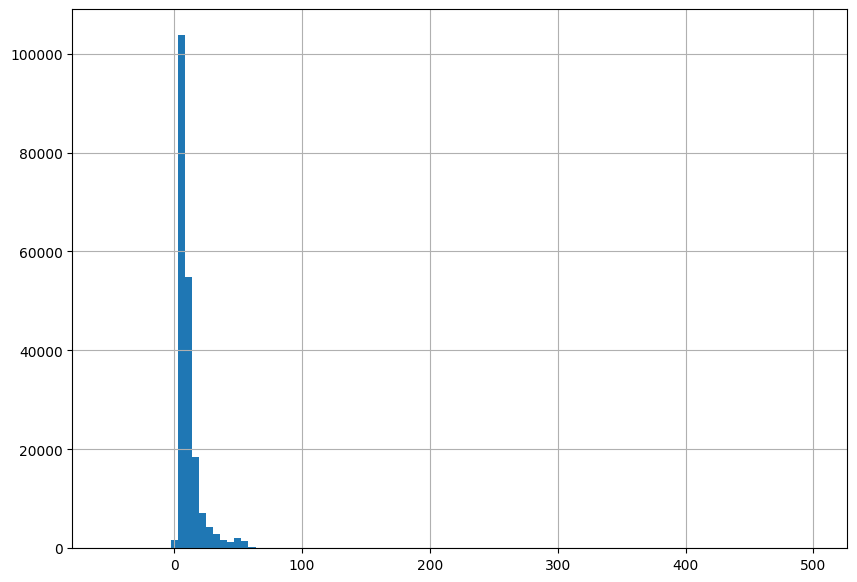

In [ ]:
uber_data['fare_amount'].hist(figsize=(10,7),bins=100)

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'fare_amount'}>,
        <Axes: title={'center': 'pickup_longitude'}>],
       [<Axes: title={'center': 'pickup_latitude'}>,
        <Axes: title={'center': 'dropoff_longitude'}>,
        <Axes: title={'center': 'dropoff_latitude'}>],
       [<Axes: title={'center': 'passenger_count'}>, <Axes: >, <Axes: >]],
      dtype=object)

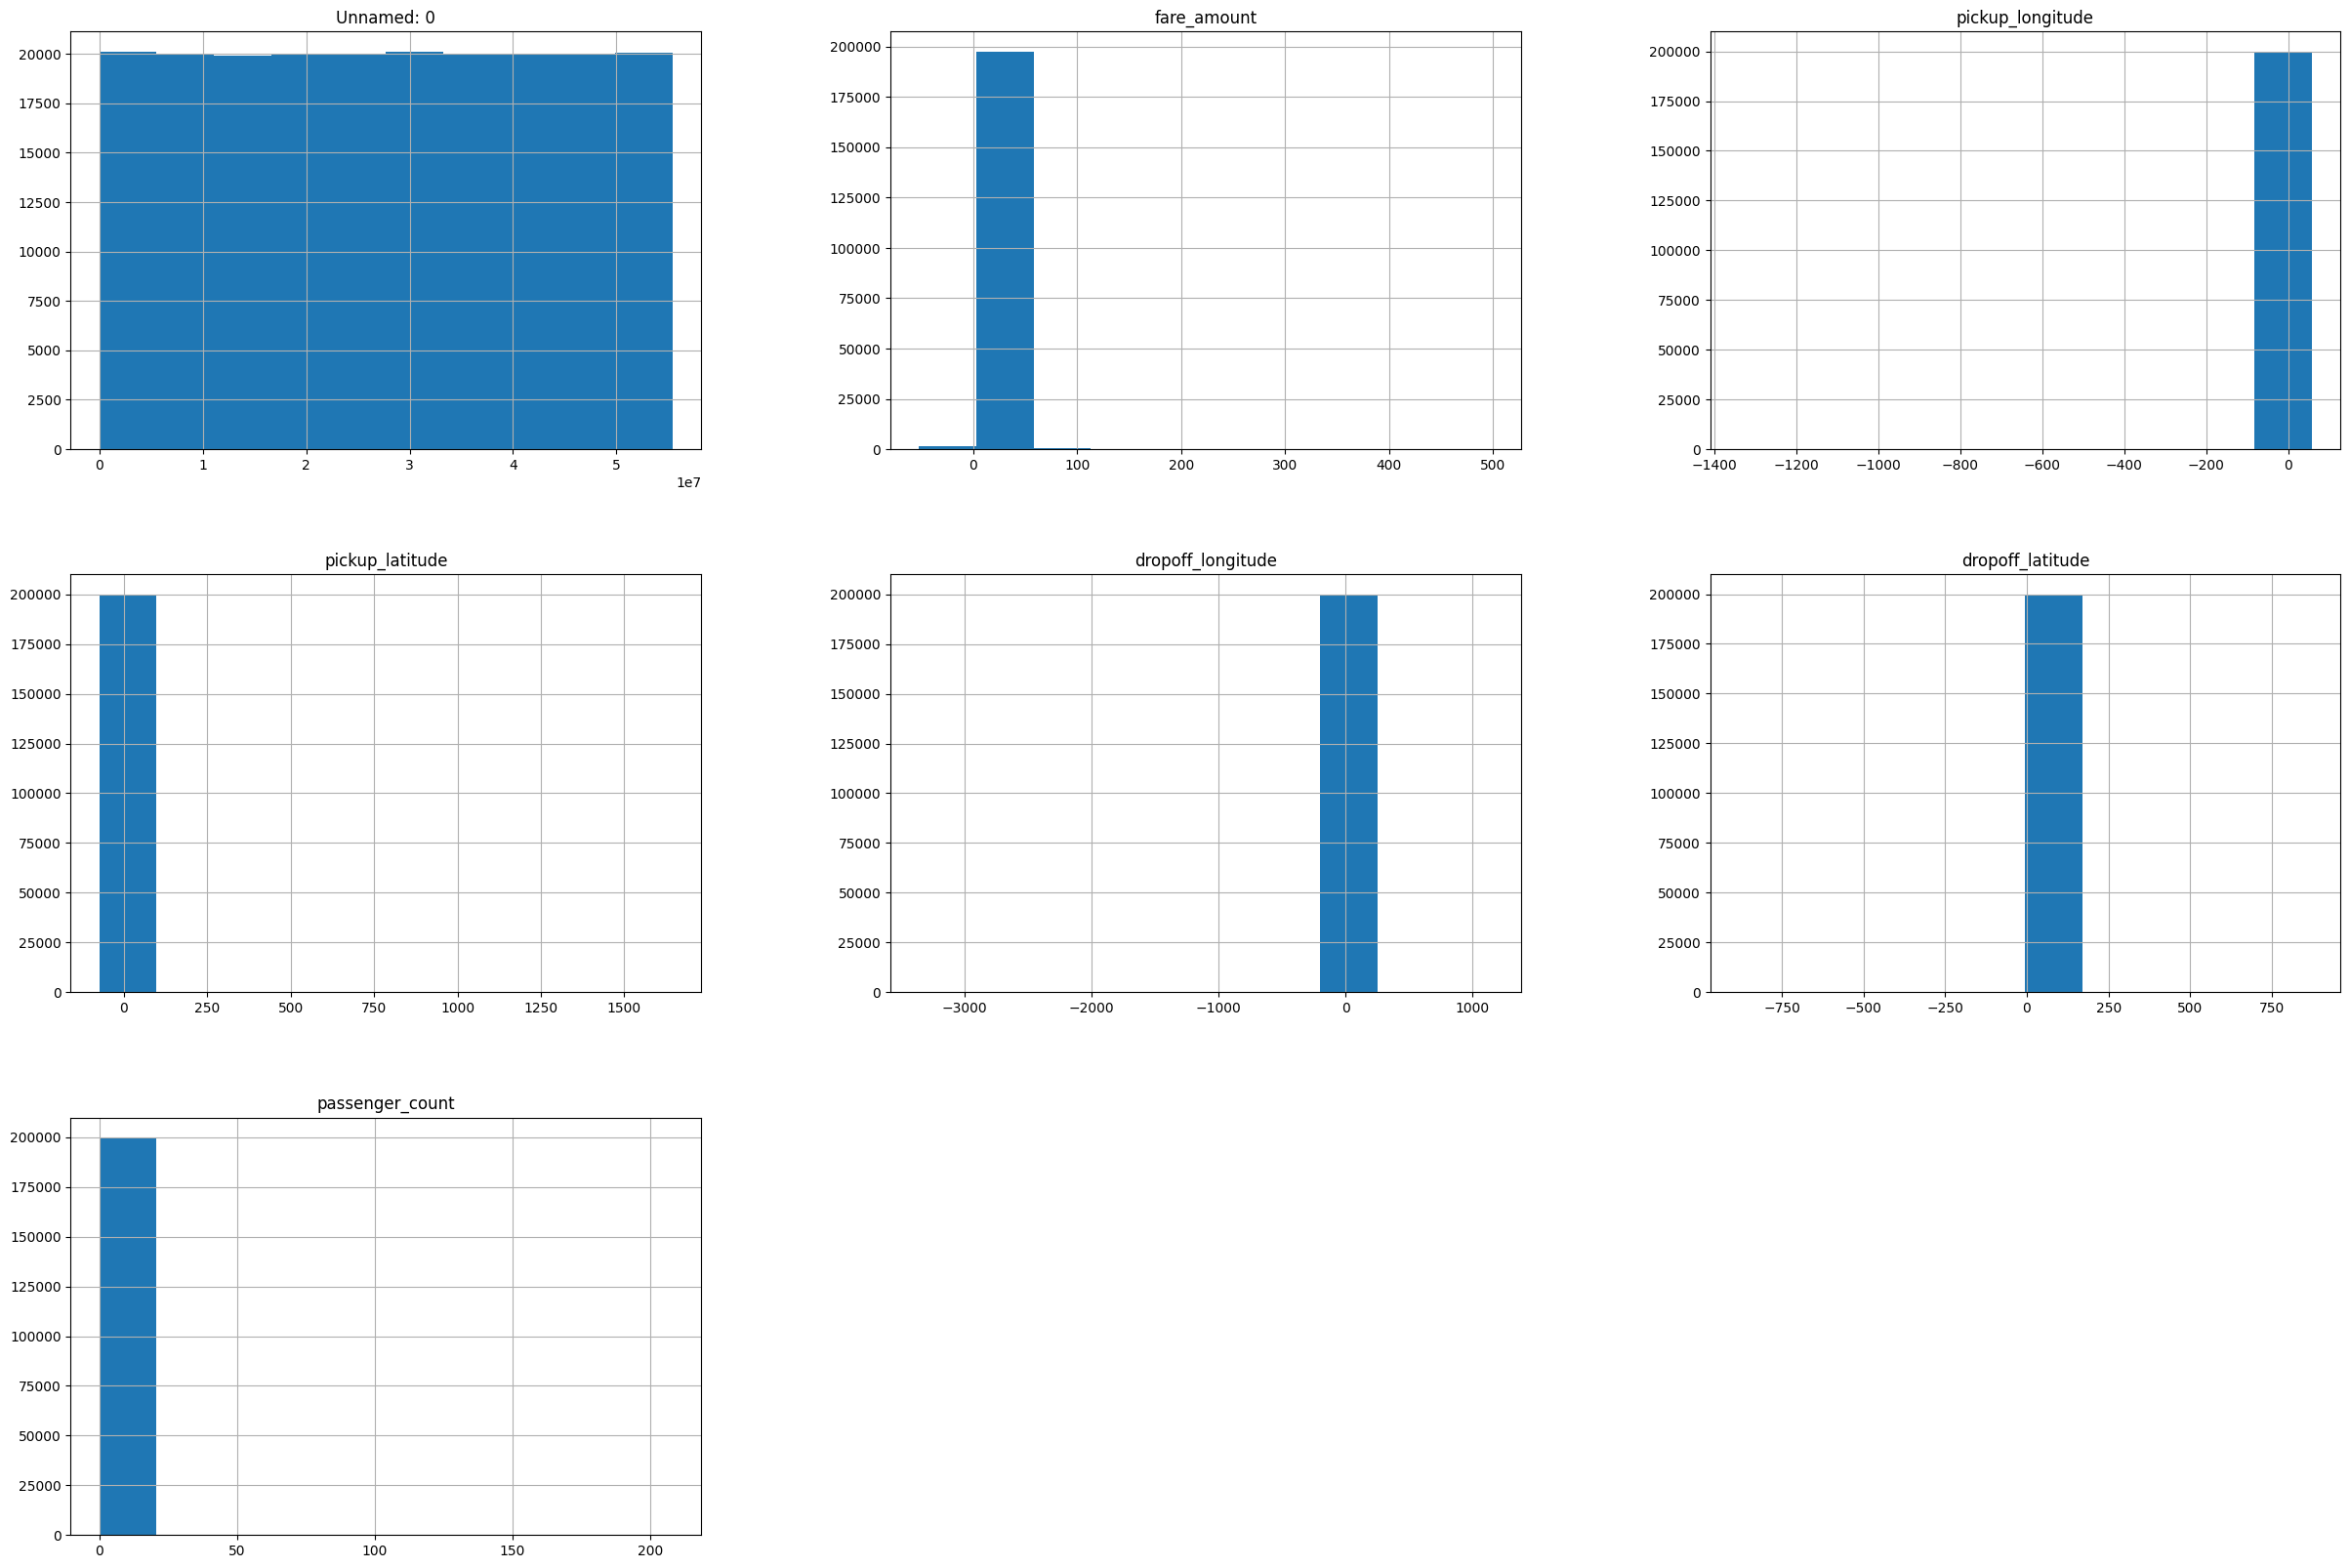

In [ ]:
uber_data.hist(figsize=(30, 20))

### Cleaning Data

#### Deleting useless

In [ ]:
uber_data.drop(columns=['Unnamed: 0', 'key'],inplace=True)

#### Calculating Distance

In [ ]:
uber_data['trip_distance'] = uber_data.apply(lambda row: h3.point_dist((row['pickup_latitude'],row['pickup_longitude']),(row['dropoff_latitude'],row['dropoff_longitude']),unit='km') , axis=1)

In [ ]:
uber_data.drop(columns=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],inplace=True)

#### Deleting null values

In [ ]:
uber_data.dropna(inplace=True)

#### Deleting outliers

In [ ]:
index_to_drop= (uber_data.loc[uber_data["fare_amount"]<1]).index
uber_data.drop(index_to_drop,inplace = True)

In [ ]:
index_to_drop= (uber_data.loc[uber_data["passenger_count"]==0]).index
uber_data.drop(index_to_drop,inplace = True)

In [ ]:
index_to_drop= (uber_data.loc[uber_data["trip_distance"]<1]).index
uber_data.drop(index_to_drop,inplace = True)

In [ ]:
uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])
uber_data['pick_up_month'] = uber_data['pickup_datetime'].dt.month
uber_data['pick_up_weekday'] = uber_data['pickup_datetime'].dt.weekday
uber_data['pick_up_hour'] = uber_data['pickup_datetime'].dt.hour
uber_data.drop(columns=['pickup_datetime'],inplace=True)

In [ ]:
columns = uber_data.columns

In [ ]:
# for c in uber_data.columns[1:]:
#   upper_bound, lower_bound,median = getLimitsAndMedian(uber_data[c])
#   uber_data.loc[(uber_data[c] > upper_bound) | (uber_data[c] < lower_bound),c]=median

### Split data

In [ ]:
columns = uber_data.columns

In [ ]:
X_uber= uber_data[columns[1:]]
Y_uber=uber_data[columns[0]]

In [ ]:
X_uber.shape[1]

5

In [ ]:
X_uber.shape

(163506, 5)

In [ ]:
X_uber

,passenger_count,trip_distance,pick_up_month,pick_up_weekday,pick_up_hour
0,1,1.683325,5,3,19
1,1,2.457593,7,4,20
2,1,5.036383,8,0,21
3,3,1.661685,6,4,8
4,5,4.475455,8,3,17
...,...,...,...,...,...
199994,1,1.122879,1,4,14
199996,1,1.875052,3,4,1
199997,2,12.850334,6,0,0
199998,1,3.539719,5,2,14


In [ ]:
Y_uber

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199994    12.0
199996     7.5
199997    30.9
199998    14.5
199999    14.1
Name: fare_amount, Length: 163506, dtype: float64

### Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_uber, Y_uber, test_size=0.20, random_state=42)

In [ ]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
uber_model = keras.Sequential()

In [ ]:
uber_model.add(layers.Dense(8, activation='relu', input_shape=(X_uber.shape[1],)))

In [ ]:
uber_model.add(layers.Dense(8, activation='relu'))

In [ ]:
uber_model.add(layers.Dense(1, activation='linear'))

In [ ]:
uber_model.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

In [ ]:
uber_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 48        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Declaración callback checkpoint ( se guarda en el directorio /tmp/checkpoints el modelo con el menor error)
callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='val_loss', mode='min',save_best_only=True)

In [ ]:
history_uber = uber_model.fit(X_train,y_train, epochs=300, batch_size=32,  validation_split=0.1, callbacks=[callback_early, callback_checkpoint])

Epoch 1/300
3659/3679 [============================>.] - ETA: 0s - loss: 320.5077

3679/3679 [==============================] - 9s 2ms/step - loss: 318.8830 - val_loss: 22.3346
Epoch 2/300
3679/3679 [==============================] - 8s 2ms/step - loss: 24.0267 - val_loss: 23.6110
Epoch 3/300
3668/3679 [============================>.] - ETA: 0s - loss: 22.9798

3679/3679 [==============================] - 8s 2ms/step - loss: 22.9443 - val_loss: 20.8300
Epoch 4/300
3679/3679 [==============================] - 9s 2ms/step - loss: 22.4962 - val_loss: 21.5182
Epoch 5/300
3679/3679 [==============================] - 10s 3ms/step - loss: 22.1283 - val_loss: 26.7773
Epoch 6/300
3679/3679 [==============================] - 8s 2ms/step - loss: 21.8558 - val_loss: 20.9513
Epoch 7/300
3678/3679 [============================>.] - ETA: 0s - loss: 21.6080

3679/3679 [==============================] - 10s 3ms/step - loss: 21.6096 - val_loss: 20.3134
Epoch 8/300
3650/3679 [============================>.] - ETA: 0s - loss: 21.2595

3679/3679 [==============================] - 8s 2ms/step - loss: 21.2489 - val_loss: 19.5329
Epoch 9/300
3660/3679 [============================>.] - ETA: 0s - loss: 43.4328

3679/3679 [==============================] - 9s 2ms/step - loss: 43.2928 - val_loss: 19.3482
Epoch 10/300
3679/3679 [==============================] - 7s 2ms/step - loss: 20.4474 - val_loss: 19.7107
Epoch 11/300
3679/3679 [==============================] - 9s 2ms/step - loss: 20.7332 - val_loss: 19.6817
Epoch 12/300
3679/3679 [==============================] - 8s 2ms/step - loss: 20.4016 - val_loss: 19.5721
Epoch 13/300
3679/3679 [==============================] - 8s 2ms/step - loss: 20.2610 - val_loss: 19.8281
Epoch 14/300
3661/3679 [============================>.] - ETA: 0s - loss: 20.2606

3679/3679 [==============================] - 8s 2ms/step - loss: 20.2543 - val_loss: 18.8003
Epoch 15/300
3679/3679 [==============================] - 7s 2ms/step - loss: 20.4544 - val_loss: 20.4970
Epoch 16/300
3679/3679 [==============================] - 8s 2ms/step - loss: 19.8349 - val_loss: 19.0009
Epoch 17/300
3679/3679 [==============================] - 7s 2ms/step - loss: 20.0481 - val_loss: 19.3133
Epoch 18/300
3679/3679 [==============================] - 8s 2ms/step - loss: 20.0698 - val_loss: 18.9746
Epoch 19/300
3679/3679 [==============================] - 7s 2ms/step - loss: 19.7817 - val_loss: 19.3546
Epoch 20/300
3679/3679 [==============================] - 9s 2ms/step - loss: 20.1943 - val_loss: 18.9639
Epoch 21/300
3679/3679 [==============================] - 7s 2ms/step - loss: 19.8161 - val_loss: 20.1908
Epoch 22/300
3679/3679 [==============================] - 8s 2ms/step - loss: 20.1325 - val_loss: 18.9994
Epoch 23/300
3679/3679 [==============================] - 7

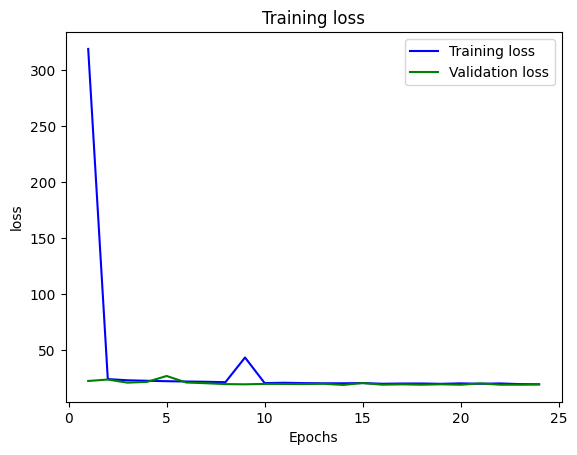

In [ ]:
loss = history_uber.history['loss']
val_loss= history_uber.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [ ]:
predictions= uber_model.predict(X_test)

1022/1022 [==============================] - 1s 1ms/step


In [ ]:
print("R^2: ", r2_score(y_test,predictions))
print("MSE: ", mean_squared_error(y_test,predictions))
print("MAE: ", mean_absolute_error(y_test,predictions))

R^2:  0.811664140332613
MSE:  17.57407079151247
MAE:  2.3716760229567173


In [ ]:
uber_model.save('/content/drive/MyDrive/uber_taller/result_model')